In [1]:
# load some necessary modules
from dmipy.core import modeling_framework
from os.path import join
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

/Users/paddyslator/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#load the example data
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


In [3]:
#setup ball and stick model
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
ballstick = MultiCompartmentModel(models=[stick, ball])

We highly recommend installing pathos to take advantage of multicore processing.


In [4]:
import asyncio
from importlib import reload

import fit_bayes
from fit_bayes import fit, tform_params  # , dict_to_array, array_to_dict
fit_bayes = reload(fit_bayes)


In [5]:
#things to note/change in the code:
#remove tqdm
#roi extraction in lines 60-65 doesn't work if 3D array and/or not reshaped
#it fails when the burn in is too small (e.g. 200 steps, 100 burn in), line 162 fails




In [6]:
#setup stuff - want to move this inside the function

#get the mask
mask_hcp = (data_hcp[..., 0]>0)


#squash down into a 2D array - single slice
mask = np.squeeze(mask_hcp)
data = np.squeeze(data_hcp)

#reshape the data
nx = data.shape[0]
ny = data.shape[1]
ndw = data.shape[2]

from copy import copy, deepcopy
# generalise
model = deepcopy(ballstick)
data = np.reshape(data_hcp, (nx*ny, ndw))
mask = np.reshape(mask_hcp, nx*ny)
    

# #in future, want to add account fot 3D array, something like this  
# #reshape the data
# nx = data_hcp.shape[0]
# ny = data_hcp.shape[1]
# nz = data_hcp.shape[2]
# ndw = data_hcp.shape[3]

# # generalise
# #model = deepcopy(BAS_mod)
# data = np.reshape(data_hcp, (nx*ny*nz, ndw))
# mask = np.reshape(mask_hcp, nx*ny*nz)  


In [22]:
nsteps=2000
burn_in=1000

acceptance_rate, param_conv, params_all_new, params_all_orig, likelihood_stored, w_stored = fit_bayes.fit(ballstick, scheme_hcp, data, mask, nsteps, burn_in)


Setup brute2fine optimizer in 0.6409628391265869 seconds
Fitting of 8181 voxels complete in 322.82091188430786 seconds.
Average of 0.03945983521382568 seconds per voxel.
ROI 1/1; 8181 voxels


/Users/paddyslator/dmipy-bayesian/fit_bayes.py:292: RuntimeWarning: divide by zero encountered in true_divide
  w[param][idx_roi] = w[param][idx_roi] * 101 / (2 * (101 - (accepted_per_100[param][idx_roi])))
/Users/paddyslator/dmipy-bayesian/fit_bayes.py:26: RuntimeWarning: invalid value encountered in true_divide
  param_dict[param] = (lb + ub * np.exp(param_dict[param])) / (1 + np.exp(param_dict[param]))
/Users/paddyslator/dmipy-bayesian/fit_bayes.py:237: RuntimeWarning: divide by zero encountered in log
  prior_new = prior_new + np.log(scipy.stats.multivariate_normal.pdf(parameter_vector, mu, sigma, allow_singular=1))
/Users/paddyslator/dmipy-bayesian/fit_bayes.py:212: RuntimeWarning: divide by zero encountered in log
  f_dept = np.log(f_dept) - np.log(1 - f_dept)  # tform dept fraction (orig -> log)
/Users/paddyslator/dmipy-bayesian/fit_bayes.py:206: RuntimeWarning: invalid value encountered in true_divide
  f_indep = np.exp(f_indep) / (1 + np.exp(f_indep))  # tform indept fractions

In [23]:
#reshape and put into correct orientation (move into the function?)

params_img = {}
for i in params_all_new.keys():
    print(i)
    if ballstick.parameter_cardinality[i] == 1:
        params_img[i] = np.reshape(params_all_new[i],(nx,ny))
        params_img[i] = np.flip(params_img[i].transpose(1,0),0)


C1Stick_1_lambda_par
G1Ball_1_lambda_iso
C1Stick_1_mu
partial_volume_1
partial_volume_0


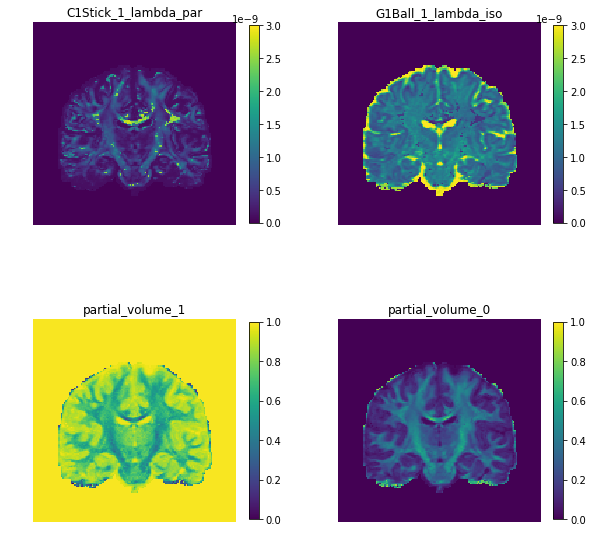

In [24]:
fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

colormap=axs[3].imshow(params_img['partial_volume_0'],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[3], shrink=0.8)
axs[3].set_title('partial_volume_0')
axs[3].set_axis_off()

colormap=axs[2].imshow(params_img['partial_volume_1'],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[2], shrink=0.8)
axs[2].set_title('partial_volume_1')
axs[2].set_axis_off()

colormap=axs[0].imshow(params_img['C1Stick_1_lambda_par'],vmin=0, vmax=3e-9)
fig.colorbar(colormap, ax=axs[0], shrink=0.8)
axs[0].set_title('C1Stick_1_lambda_par')
axs[0].set_axis_off()

colormap=axs[1].imshow(params_img['G1Ball_1_lambda_iso'],vmin=0, vmax=3e-9)
fig.colorbar(colormap, ax=axs[1], shrink=0.8)
axs[1].set_title('G1Ball_1_lambda_iso')
axs[1].set_axis_off()



In [10]:
#lsq fit for comparison (could output this from the fit_bayes function?)
BAS_fit_hcp = ballstick.fit(scheme_hcp, data_hcp, mask_hcp)


Setup brute2fine optimizer in 0.2396249771118164 seconds
Fitting of 8181 voxels complete in 175.5159559249878 seconds.
Average of 0.021454095578167437 seconds per voxel.


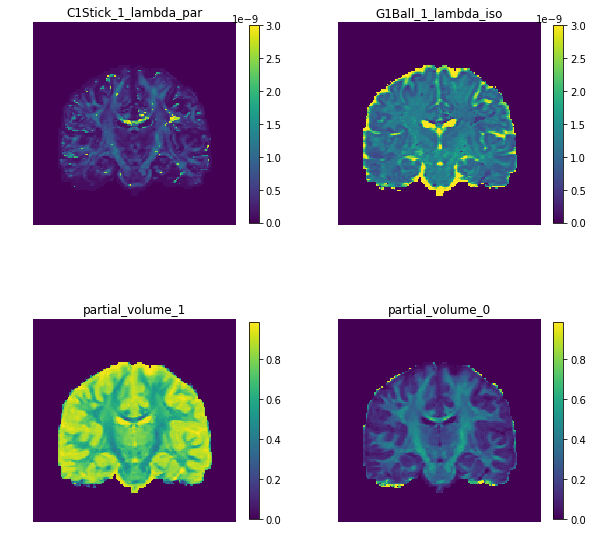

In [11]:
#plot lsq maps 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fitted_parameters = BAS_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.8)
    counter += 1



In [12]:
#TO DO plot some example MCMC chains

In [14]:
#TO DO plot the inferred prior distributions


In [15]:
#NODDI

from dmipy.signal_models import cylinder_models, gaussian_models
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()

from dmipy.distributions.distribute_models import SD1WatsonDistributed
watson_dispersed_bundle = SD1WatsonDistributed(models=[stick, zeppelin])

watson_dispersed_bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
watson_dispersed_bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
#see what happens when you don't fix the diffusivities!
#watson_dispersed_bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)

from dmipy.core.modeling_framework import MultiCompartmentModel
NODDI_mod = MultiCompartmentModel(models=[ball, watson_dispersed_bundle])

#NODDI_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

We highly recommend installing pathos to take advantage of multicore processing.


In [16]:

model = deepcopy(NODDI_mod)

data = np.reshape(data_hcp, (nx*ny, ndw))
mask = np.reshape(mask_hcp, nx*ny)



In [17]:
nsteps=2000
burn_in=1000

acceptance_rate, param_conv, params_all_new, params_all_orig, likelihood_stored, w_stored = fit_bayes.fit(NODDI_mod, scheme_hcp, data, mask, nsteps, burn_in)


Setup brute2fine optimizer in 29.79390001296997 seconds
Fitting of 8181 voxels complete in 1196.4467360973358 seconds.
Average of 0.1462470035566967 seconds per voxel.
ROI 1/1; 8181 voxels


/Users/paddyslator/dmipy-bayesian/fit_bayes.py:292: RuntimeWarning: divide by zero encountered in true_divide
  w[param][idx_roi] = w[param][idx_roi] * 101 / (2 * (101 - (accepted_per_100[param][idx_roi])))
/Users/paddyslator/dmipy-bayesian/fit_bayes.py:26: RuntimeWarning: invalid value encountered in true_divide
  param_dict[param] = (lb + ub * np.exp(param_dict[param])) / (1 + np.exp(param_dict[param]))
/Users/paddyslator/dmipy-bayesian/fit_bayes.py:237: RuntimeWarning: divide by zero encountered in log
  prior_new = prior_new + np.log(scipy.stats.multivariate_normal.pdf(parameter_vector, mu, sigma, allow_singular=1))
/Users/paddyslator/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/paddyslator/dmipy-bayesian/fit_bayes.py:206: RuntimeWarning: invalid value encountered in true_divide
  f_indep = np.exp(f_indep) / (1 + np.exp(f_indep))  # tform indept fractions

In [18]:
#reshape and put into correct orientation (move into the function?)

params_img = {}
params_img_orig = {}

for i in params_all_new.keys():
    print(i)
    if NODDI_mod.parameter_cardinality[i] == 1:
        params_img[i] = np.reshape(params_all_new[i],(nx,ny))
        params_img[i] = np.flip(params_img[i].transpose(1,0),0)
        
        params_img_orig[i] = np.reshape(params_all_orig[i],(nx,ny))
        params_img_orig[i] = np.flip(params_img_orig[i].transpose(1,0),0)

        

SD1WatsonDistributed_1_SD1Watson_1_mu
not working yet! params_all_new seems too big for orientation parameters
partial_volume_0
SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par
SD1WatsonDistributed_1_partial_volume_0
G1Ball_1_lambda_iso
SD1WatsonDistributed_1_SD1Watson_1_odi
partial_volume_1


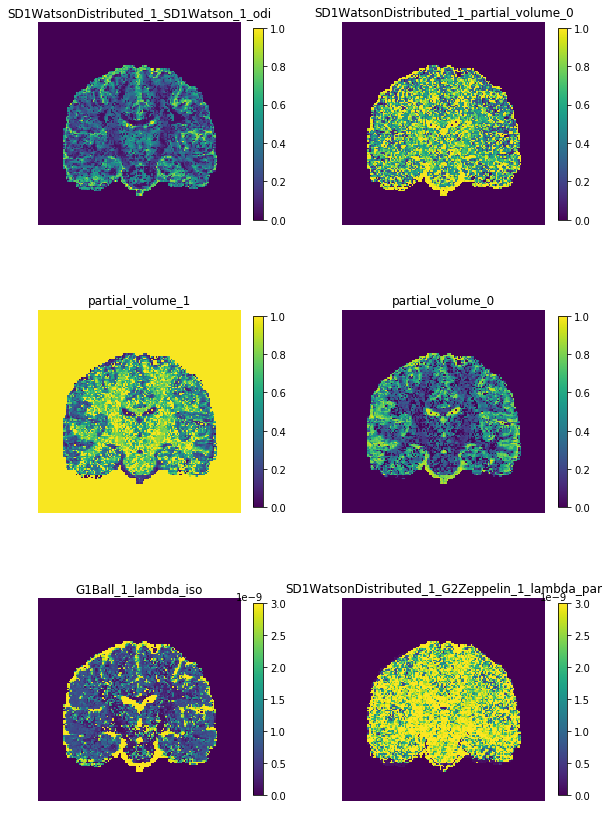

In [19]:
#plot the Bayesian fit

fig, axs = plt.subplots(3, 2, figsize=[10, 15])
axs = axs.ravel()

colormap=axs[0].imshow(params_img['SD1WatsonDistributed_1_SD1Watson_1_odi'],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[0], shrink=0.8)
axs[0].set_title('SD1WatsonDistributed_1_SD1Watson_1_odi')
axs[0].set_axis_off()

colormap=axs[1].imshow(params_img['SD1WatsonDistributed_1_partial_volume_0'],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[1], shrink=0.8)
axs[1].set_title('SD1WatsonDistributed_1_partial_volume_0')
axs[1].set_axis_off()

colormap=axs[2].imshow(params_img['partial_volume_1'],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[2], shrink=0.8)
axs[2].set_title('partial_volume_1')
axs[2].set_axis_off()

colormap=axs[3].imshow(params_img['partial_volume_0'],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[3], shrink=0.8)
axs[3].set_title('partial_volume_0')
axs[3].set_axis_off()

colormap=axs[4].imshow(params_img['G1Ball_1_lambda_iso'],vmin=0, vmax=3e-09)
fig.colorbar(colormap, ax=axs[4], shrink=0.8)
axs[4].set_title('G1Ball_1_lambda_iso')
axs[4].set_axis_off()

colormap=axs[5].imshow(params_img['SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par'],vmin=0, vmax=3e-09)
fig.colorbar(colormap, ax=axs[5], shrink=0.8)
axs[5].set_title('SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par')
axs[5].set_axis_off()




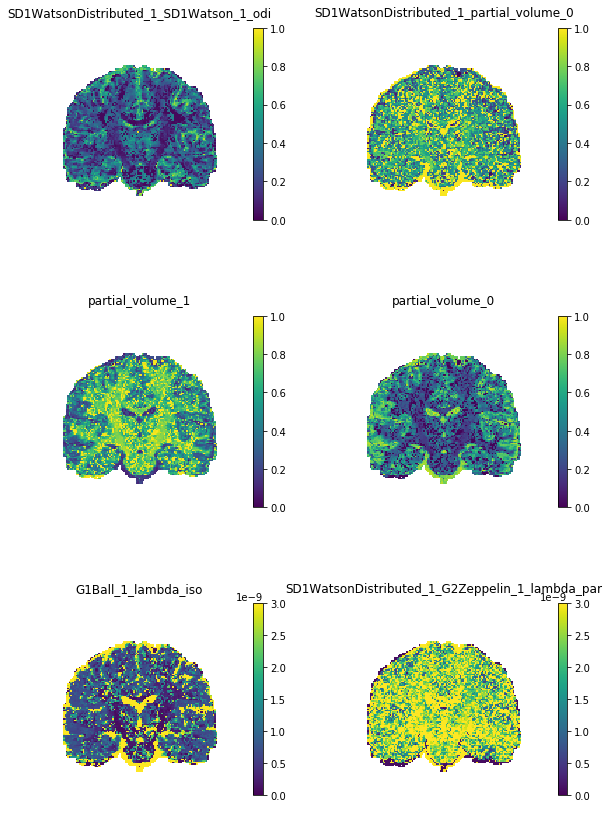

In [20]:
#plot the LSQ fit

fig, axs = plt.subplots(3, 2, figsize=[10, 15])
axs = axs.ravel()

colormap=axs[0].imshow(params_img_orig['SD1WatsonDistributed_1_SD1Watson_1_odi'],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[0], shrink=0.8)
axs[0].set_title('SD1WatsonDistributed_1_SD1Watson_1_odi')
axs[0].set_axis_off()

colormap=axs[1].imshow(params_img_orig['SD1WatsonDistributed_1_partial_volume_0'],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[1], shrink=0.8)
axs[1].set_title('SD1WatsonDistributed_1_partial_volume_0')
axs[1].set_axis_off()

colormap=axs[2].imshow(params_img_orig['partial_volume_1'],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[2], shrink=0.8)
axs[2].set_title('partial_volume_1')
axs[2].set_axis_off()

colormap=axs[3].imshow(params_img_orig['partial_volume_0'],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[3], shrink=0.8)
axs[3].set_title('partial_volume_0')
axs[3].set_axis_off()

colormap=axs[4].imshow(params_img_orig['G1Ball_1_lambda_iso'],vmin=0, vmax=3e-09)
fig.colorbar(colormap, ax=axs[4], shrink=0.8)
axs[4].set_title('G1Ball_1_lambda_iso')
axs[4].set_axis_off()

colormap=axs[5].imshow(params_img_orig['SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par'],vmin=0, vmax=3e-09)
fig.colorbar(colormap, ax=axs[5], shrink=0.8)
axs[5].set_title('SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par')
axs[5].set_axis_off()
